# Face Recognition Project

In [48]:
!nvidia-smi

Wed Nov 15 11:02:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |  14569MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Import dataset

In [49]:
import zipfile
import os

In [50]:
# Download and extract dataset PINS_10
!gdown 1nEHL0YHxAeG8A-pTkouBkywTPj22Yp_4
with zipfile.ZipFile('pins_celebs.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

Downloading...
From: https://drive.google.com/uc?id=1nEHL0YHxAeG8A-pTkouBkywTPj22Yp_4
To: /content/pins_celebs.zip
100% 46.7M/46.7M [00:00<00:00, 238MB/s]


In [51]:
#!gdown 1o2TkrzwObdbmlAOHdD-h8AegGi4jcYTw
#pins face full dataset

## 2. Preparing training and validation set

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers, models, applications
import tensorflow as tf

In [53]:
img_dir = os.path.join(os.getcwd(), 'pins_celebs')

In [54]:
# Define batch size and target shape 1
batch_size = 128
target_shape = (160, 160)

In [74]:
# Define batch size and target shape 2
batch_size = 64
target_shape = (160, 160)

In [111]:
# Define batch size and target shape 3
batch_size = 32
target_shape = (160, 160)

In [112]:
# Set training directory
train_dir = os.path.join(os.getcwd(), 'pins_celebs')

In [113]:
# Load and preprocess the dataset
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    seed=3710,
    subset="both",
    image_size=target_shape,
    batch_size=batch_size)

Found 1671 files belonging to 10 classes.
Using 1337 files for training.
Using 334 files for validation.


In [114]:
class_names = train_ds.class_names
class_names

['pins_Adriana Lima',
 'pins_Chris Hemsworth',
 'pins_Dwayne Johnson',
 'pins_Henry Cavil',
 'pins_Jason Momoa',
 'pins_Morgan Freeman',
 'pins_Rihanna',
 'pins_Shakira Isabel Mebarak',
 'pins_Zoe Saldana',
 'pins_scarlett johansson']

In [115]:
train_ds.class_names == val_ds.class_names

True

## 3. Building model with [`xception`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception) as base model

### Data augmentation

In [116]:
# Data Augmentation Layer
# contrast + brightness distortion
class RandomColorDistortion(tf.keras.layers.Layer):
  def __init__(self, contrast_range=[0.75, 1.25],
               brightness_delta=[-0.1, 0.1], **kwargs):
    super(RandomColorDistortion, self).__init__(**kwargs)
    self.contrast_range = contrast_range
    self.brightness_delta = brightness_delta

  def call(self, images, training=False):
    if not training:
      return images
    contrast = np.random.uniform(
    self.contrast_range[0], self.contrast_range[1])
    brightness = np.random.uniform(
    self.brightness_delta[0], self.brightness_delta[1])



    images = tf.image.adjust_contrast(images, contrast)
    images = tf.image.adjust_brightness(images, brightness)
    images = tf.clip_by_value(images, 0, 255)
    return images

In [117]:
# Data Augmentation Layer
# plip + rotation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  RandomColorDistortion(name='random_contrast_brightness/none'),
  ], name='augmentation_layer')

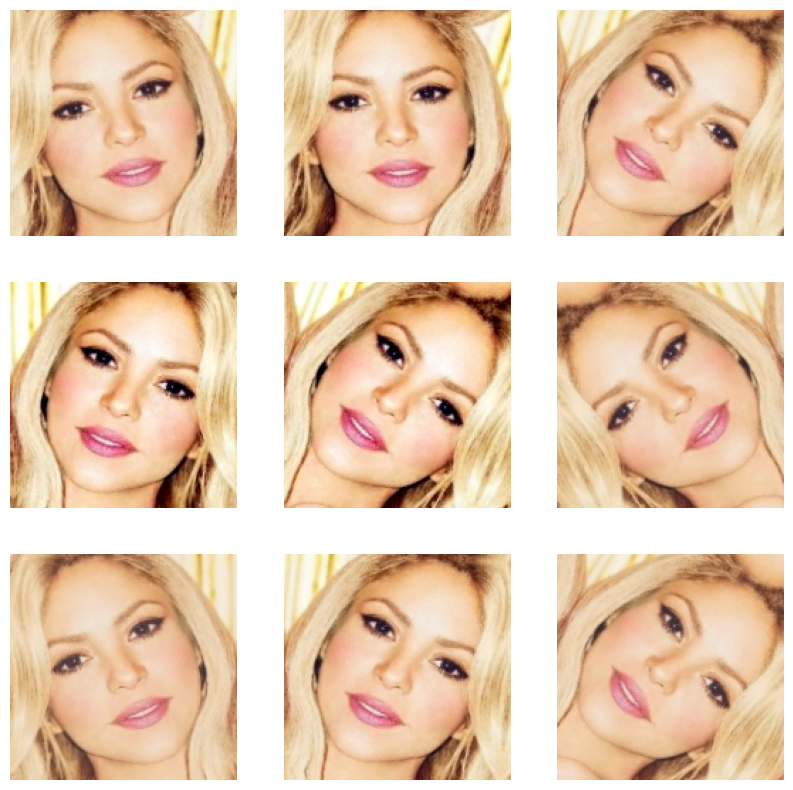

In [118]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis('off')

### Preprocessing inputs

In [119]:
#from tensorflow.keras.applications import xception

preprocess_input = applications.inception_resnet_v2.preprocess_input


### Base model


In [120]:
from tensorflow.keras.applications import Xception

base_model = Xception(weights="imagenet",
                      input_shape=target_shape + (3,),
                      include_top=False)

In [121]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 79, 79, 32)           864       ['input_9[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 79, 79, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 79, 79, 32)           0         ['block1_conv1_bn[0][0]

# Fine tuning

In [136]:
# the following commented lines are fine tuning

trainable = False
number_of_layer=0
for layer in base_model.layers:
    number_of_layer+=1
    #if layer.name == "block13_sepconv1_act":
    trainable = True
    layer.trainable = trainable



In [137]:
# this is He initialization of the weights

init = tf.keras.initializers.HeUniform(seed=3710) # GlorotUniform() is also a good choice, feel free to explore
for w in base_model.trainable_variables:
    w.assign(init(w.shape))


### Model output

In [138]:
pooling_layer = tf.keras.layers.GlobalMaxPooling2D()


### Assemble layers

In [139]:

inputs = tf.keras.Input(shape=target_shape + (3,))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(inputs)
x = pooling_layer(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = layers.Dense(128, activation='relu', name='embeddings')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = layers.Dense(len(train_ds.class_names),
                       activation=tf.keras.activations.softmax)(x)
model = tf.keras.Model(inputs, outputs)





In [140]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_max_pooling2d_5 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 embeddings (Dense)          (None, 128)               262272    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                           

In [141]:
for layer in model.layers:
  print(layer.name)

input_11
xception
global_max_pooling2d_5
dropout_10
embeddings
dropout_11
dense_5


### Choosing optimizers

In [142]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Create callbacks to stop training when target goal is reached

In [143]:
class CustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs['val_accuracy']
        acc = logs['accuracy']
        if val_acc >= 0.8 and np.abs(val_acc-acc)<0.04:
            self.model.stop_training = True
            print("goal reached\n")
        print('\n')
        print("End epoch {} of training\n".format(epoch))
        print('-------------------------------------------')

### If you don't want to train, skip the following cell, use my trained weights

# TRAINING

In [144]:
epochs=30
customCallback = CustomCallback()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[customCallback]
)

Epoch 1/30
 6/42 [===>..........................] - ETA: 8s - loss: 2.2954 - accuracy: 0.0833

42/42 [==============================] - ETA: 0s - loss: 2.2972 - accuracy: 0.1062

End epoch 0 of training

-------------------------------------------
42/42 [==============================] - 37s 308ms/step - loss: 2.2972 - accuracy: 0.1062 - val_loss: 2.2837 - val_accuracy: 0.1257
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 2.2731 - accuracy: 0.1227

End epoch 1 of training

-------------------------------------------
42/42 [==============================] - 12s 277ms/step - loss: 2.2731 - accuracy: 0.1227 - val_loss: 2.2932 - val_accuracy: 0.1257
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 2.1678 - accuracy: 0.1840

End epoch 2 of training

-------------------------------------------
42/42 [==============================] - 12s 288ms/step - loss: 2.1678 - accuracy: 0.1840 - val_loss: 2.2835 - val_accuracy: 0.1257
Epoch 4/30
42/42 [==============================] - ETA: 0s - loss: 2.0108 - accuracy: 0.2685

End epoch 3 of training

---

In [147]:
# Save the weights after training
from google.colab import drive
drive.mount('/content/drive')



#weights_path = '/content/drive/My Drive/FaceRecProject_Lina/Xception_10pins_128_160x160_yes_yes.h5'
#weights_path = '/content/drive/My Drive/FaceRecProject_Lina/Xception_10pins_128_160x160_yes_no.h5'

#weights_path = '/content/drive/My Drive/FaceRecProject_Lina/Xception_10pins_64_160x160_yes_yes.h5'
#weights_path = '/content/drive/My Drive/FaceRecProject_Lina/Xception_10pins_64_160x160_yes_no.h5'

#weights_path = '/content/drive/My Drive/FaceRecProject_Lina/Xception_10pins_32_160x160_yes_yes.h5'
#weights_path = '/content/drive/My Drive/FaceRecProject_Lina/Xception_10pins_32_160x160_yes_no.h5'



model.save_weights(weights_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
import pandas as pd

pd.DataFrame(history.history).to_csv('xception_10PINS.csv')


#csv_path = '/content/drive/My Drive/FaceRecProject_Lina/Xception_10pins_128_160x160_yes_yes.csv'
#csv_path = '/content/drive/My Drive/FaceRecProject_Lina/Xception_10pins_128_160x160_yes_no.csv'

#csv_path = '/content/drive/My Drive/FaceRecProject_Lina/Xception_10pins_64_160x160_yes_yes.csv'
#csv_path = '/content/drive/My Drive/FaceRecProject_Lina/Xception_10pins_64_160x160_yes_no.csv'

#csv_path = '/content/drive/My Drive/FaceRecProject_Lina/Xception_10pins_32_160x160_yes_yes.csv'
#csv_path = '/content/drive/My Drive/FaceRecProject_Lina/Xception_10pins_32_160x160_yes_no.csv'


pd.DataFrame(history.history).to_csv(csv_path)


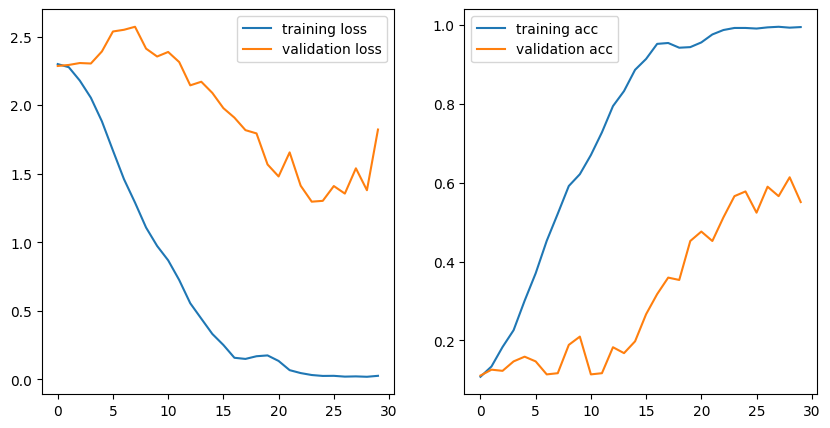

In [98]:
import matplotlib.pyplot as plt

training_loss, training_acc = history.history['loss'], history.history['accuracy']
val_loss, val_acc = history.history['val_loss'], history.history['val_accuracy']

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(training_loss, label='training loss')
ax[0].plot(val_loss, label='validation loss')
ax[0].legend()

ax[1].plot(training_acc, label='training acc')
ax[1].plot(val_acc, label='validation acc')
ax[1].legend()

### download the weights I trained below

In [37]:
!gdown 1n9lLe_fuRSEbnphhmPbNvX80xe1xWuQg

Downloading...
From: https://drive.google.com/uc?id=1n9lLe_fuRSEbnphhmPbNvX80xe1xWuQg
To: /content/weights_resnet50.tar
100% 157M/157M [00:01<00:00, 124MB/s]


In [38]:
!tar -xf weights_resnet50.tar

In [39]:
model.load_weights('./checkpoints/val_acc_0.92')

ValueError: ignored

In [ ]:
model.evaluate(train_ds)

21/21 [==============================] - 4s 154ms/step - loss: 0.0448 - accuracy: 0.9888


[0.044794343411922455, 0.9887808561325073]

In [ ]:
model.evaluate(val_ds)

6/6 [==============================] - 1s 130ms/step - loss: 1.9070 - accuracy: 0.5599


[1.9070301055908203, 0.559880256652832]

### After training, you can save your weights here

In [43]:
model.save_weights('./checkpoints/val_acc_0.92') # create a new folder, and use file name as you wish

In [ ]:
!tar -czvf weights.tar checkpoints/

checkpoints/
checkpoints/val_acc_0.92.index
checkpoints/checkpoint
checkpoints/val_acc_0.92.data-00000-of-00001


### Option for save the whole model (I think this is better)

In [ ]:
model_folder = 'resnet50_val_0.92'

In [ ]:
model.save(model_folder)

In [ ]:
!tar -czvf resnest50_val_92.tar resnet50_val_0.92

resnet50_val_0.92/
resnet50_val_0.92/assets/
resnet50_val_0.92/keras_metadata.pb
resnet50_val_0.92/fingerprint.pb
resnet50_val_0.92/saved_model.pb
resnet50_val_0.92/variables/
resnet50_val_0.92/variables/variables.data-00000-of-00001
resnet50_val_0.92/variables/variables.index


In [ ]:
!gdown 1m_HH7EmVk8eSV_X6ep5Csr4Uo6KTJPHG

Downloading...
From: https://drive.google.com/uc?id=1m_HH7EmVk8eSV_X6ep5Csr4Uo6KTJPHG
To: /content/resnest50_val_92.tar
100% 88.7M/88.7M [00:00<00:00, 137MB/s]


In [ ]:
!tar -xf resnest50_val_92.tar

In [ ]:
a = tf.keras.saving.load_model('resnet50_val_0.92')

In [ ]:
for layer in a.layers:
  print(layer.name)

input_11
augmentation_layer
tf.__operators__.getitem_3
tf.nn.bias_add_3
resnet50
global_average_pooling2d_2
embeddings
dense_6


In [ ]:
a.evaluate(val_ds)

5/5 [==============================] - 9s 21ms/step - loss: 0.2867 - accuracy: 0.9200


[0.28668105602264404, 0.9200000166893005]

### For the next cells, upload your own images to play with. Have fun

In [44]:
img = tf.keras.utils.load_img(
    'geralt.jpeg', target_size=target_shape
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = preprocess_input(img_array)
img_array.shape

TensorShape([1, 160, 160, 3])

This image most likely belongs to pins_Rihanna with a 37.64 percent confidence.


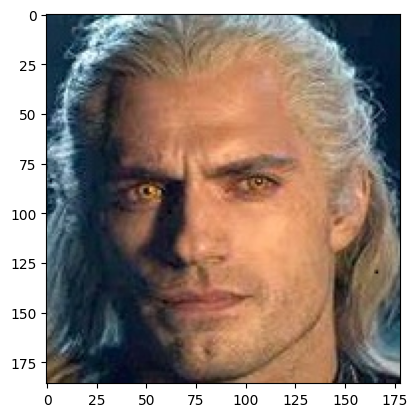

In [45]:
import PIL

plt.imshow(PIL.Image.open('geralt.jpeg'));

predictions = model(img_array, training=False)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)


In [46]:
tf.reduce_sum(predictions)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [47]:
model.predict(img_array)

1/1 [==============================] - 1s 1s/step


array([[0.04551267, 0.04512572, 0.1130954 , 0.03042372, 0.0223338 ,
        0.00588295, 0.37639895, 0.01719425, 0.30826616, 0.03576632]],
      dtype=float32)